In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/115l82GBgu6RETopB_Qy36hn4TVwXI2t5?usp=sharing

Retrieving folder list
Retrieving folder 11d7VrWFWAYhRYNunOqxh9NB8w4v9A3qZ ASR
Processing file 11fi-H85GZXViJcQAVrCU795VwNZEDn4J SampleSubmission_Advanced.csv
Processing file 11fC7u77MI_VFXYMonvfE6OG6ceMJwg62 Test_Advanced.csv
Processing file 11laIrUawzGPJeYElyhd74rV0fWagUV9z Test_Advanced.zip
Processing file 11i6Tp65-jb7oRVs88x2a9RT9SZOIBLTC Train.csv
Processing file 11vNnWvfUuEw2Edi7A9uooMRzx9LZvE_X Train.zip
Processing file 11fvM0QRXOTcwJZ6Un1iHfcQXTCAkxDK4 VariableDefinitions.csv
Retrieving folder 118cBpTcSa4wSFl2XZKJqROSYUc_4xRaM CV
Processing file 11aDBT3mGTUW0aeHGZZiZ9NvgrgvcNL2B SampleSubmission.csv
Processing file 11Ej9VAaPnxGZ_ba_NxR0T40mXhv1gFAc suspects.zip
Processing file 11HzgKOjbaRAx-9GRWgSFUgvs0RVOl95M test.csv
Processing file 11_3t37iY_tliUI3gfIUNiW75GA3cluEy Test.zip
Processing file 11NrH9PTNOl1N9VItC40FZqrK4CuWofOW train_labels.zip
Processing file 11cLzogj77zlNTqQYywxJoY8CpGMwbir- Train.zip
Processing file 11RbAfmgH-TXPTGmdtZU6BGV6BEhOOnzq val_labels.zip
Processing f

Labels are reannotated using the boiler plate code provided (https://github.com/til-23/til-23-cv/blob/main/src/object_detection/reannotate.py)

In [ ]:
!mkdir "/content/Datasets"
!mkdir "/content/Datasets/images"
!mkdir "/content/Datasets/images/train"
!mkdir "/content/Datasets/images/val"
!mkdir "/content/Datasets/images/test"
!mkdir "/content/Datasets/labels"
!mkdir "/content/Datasets/labels/val"
!mkdir "/content/Datasets/labels/train"

!unzip "/content/drive/MyDrive/OD/labels.zip" -d "/content/Datasets/labels" # Pre-reannotated labels
!unzip "/content/Advanced/CV/Train.zip" -d "/content/Datasets/images/train"
!unzip "/content/Advanced/CV/Validation.zip" -d "/content/Datasets/images/val"
!unzip "/content/Advanced/CV/Test.zip" -d "/content/Datasets/images/test"

#**Training Yolov8x**

Source: https://github.com/ultralytics/ultralytics

In [ ]:
from ultralytics import YOLO

DATASET_FOLDER = "/content/Datasets"

ROOT = "/content/drive/MyDrive/OD"
# Load a model
model = YOLO("yolov8x.pt")  # load a pretrained model (recommended for training)

# Use the model
model.train(data=ROOT + "/config.yaml", epochs=3, imgsz = 640)  # train the model


Ultralytics YOLOv8.0.111 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/drive/MyDrive/OD/config.yaml, epochs=3, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=Fals

In [ ]:
# Copy to local storage
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!cp -r "/content/runs/detect/train2" "/content/drive/MyDrive/OD"

#**Check if finetuned Yolov8x is working properly**

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("/content/drive/MyDrive/OD/train2/weights/best.pt")  

In [ ]:
# Adapted from: https://inside-machinelearning.com/en/bounding-boxes-python-function/
from google.colab.patches import cv2_imshow

import cv2

def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)
    
def plot_bboxes(image, boxes, labels=[], colors=[], score=True, conf=None):
  #Define COCO Labels
  if labels == []:
    labels = {1: u'toy'}
  #Define colors
  if colors == []:
    #colors = [(6, 112, 83), (253, 246, 160), (40, 132, 70), (205, 97, 162), (149, 196, 30), (106, 19, 161), (127, 175, 225), (115, 133, 176), (83, 156, 8), (182, 29, 77), (180, 11, 251), (31, 12, 123), (23, 6, 115), (167, 34, 31), (176, 216, 69), (110, 229, 222), (72, 183, 159), (90, 168, 209), (195, 4, 209), (135, 236, 21), (62, 209, 199), (87, 1, 70), (75, 40, 168), (121, 90, 126), (11, 86, 86), (40, 218, 53), (234, 76, 20), (129, 174, 192), (13, 18, 254), (45, 183, 149), (77, 234, 120), (182, 83, 207), (172, 138, 252), (201, 7, 159), (147, 240, 17), (134, 19, 233), (202, 61, 206), (177, 253, 26), (10, 139, 17), (130, 148, 106), (174, 197, 128), (106, 59, 168), (124, 180, 83), (78, 169, 4), (26, 79, 176), (185, 149, 150), (165, 253, 206), (220, 87, 0), (72, 22, 226), (64, 174, 4), (245, 131, 96), (35, 217, 142), (89, 86, 32), (80, 56, 196), (222, 136, 159), (145, 6, 219), (143, 132, 162), (175, 97, 221), (72, 3, 79), (196, 184, 237), (18, 210, 116), (8, 185, 81), (99, 181, 254), (9, 127, 123), (140, 94, 215), (39, 229, 121), (230, 51, 96), (84, 225, 33), (218, 202, 139), (129, 223, 182), (167, 46, 157), (15, 252, 5), (128, 103, 203), (197, 223, 199), (19, 238, 181), (64, 142, 167), (12, 203, 242), (69, 21, 41), (177, 184, 2), (35, 97, 56), (241, 22, 161)]
    colors = [(89, 161, 197),(67, 161, 255),(19, 222, 24),(186, 55, 2),(167, 146, 11),(190, 76, 98),(130, 172, 179),(115, 209, 128),(204, 79, 135),(136, 126, 185),(209, 213, 45),(44, 52, 10),(101, 158, 121),(179, 124, 12),(25, 33, 189),(45, 115, 11),(73, 197, 184),(62, 225, 221),(32, 46, 52),(20, 165, 16),(54, 15, 57),(12, 150, 9),(10, 46, 99),(94, 89, 46),(48, 37, 106),(42, 10, 96),(7, 164, 128),(98, 213, 120),(40, 5, 219),(54, 25, 150),(251, 74, 172),(0, 236, 196),(21, 104, 190),(226, 74, 232),(120, 67, 25),(191, 106, 197),(8, 15, 134),(21, 2, 1),(142, 63, 109),(133, 148, 146),(187, 77, 253),(155, 22, 122),(218, 130, 77),(164, 102, 79),(43, 152, 125),(185, 124, 151),(95, 159, 238),(128, 89, 85),(228, 6, 60),(6, 41, 210),(11, 1, 133),(30, 96, 58),(230, 136, 109),(126, 45, 174),(164, 63, 165),(32, 111, 29),(232, 40, 70),(55, 31, 198),(148, 211, 129),(10, 186, 211),(181, 201, 94),(55, 35, 92),(129, 140, 233),(70, 250, 116),(61, 209, 152),(216, 21, 138),(100, 0, 176),(3, 42, 70),(151, 13, 44),(216, 102, 88),(125, 216, 93),(171, 236, 47),(253, 127, 103),(205, 137, 244),(193, 137, 224),(36, 152, 214),(17, 50, 238),(154, 165, 67),(114, 129, 60),(119, 24, 48),(73, 8, 110)]
  
  #plot each boxes
  for box in boxes:
    #add score in label if score=True
    if score :
      label = labels[int(box[-1])+1] + " " + str(round(100 * float(box[-2]),1)) + "%"
    else :
      label = labels[int(box[-1])+1]
    #filter every box under conf threshold if conf threshold setted
    if conf :
      if box[-2] > conf:
        color = colors[int(box[-1])]
        box_label(image, box, label, color)
    else:
      color = colors[int(box[-1])]
      box_label(image, box, label, color)

  #show image
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  try:
    import google.colab
    IN_COLAB = True
  except:
    IN_COLAB = False

  if IN_COLAB:
    cv2_imshow(image) #if used in Colab
  else :
    cv2.imshow(image) #if used in Python

In [ ]:
result = model.predict("/content/Datasets/images/val/image_0000.png")


image 1/1 /content/Datasets/images/test/image_0000.png: 384x640 3 Toyss, 62.4ms
Speed: 1.7ms preprocess, 62.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


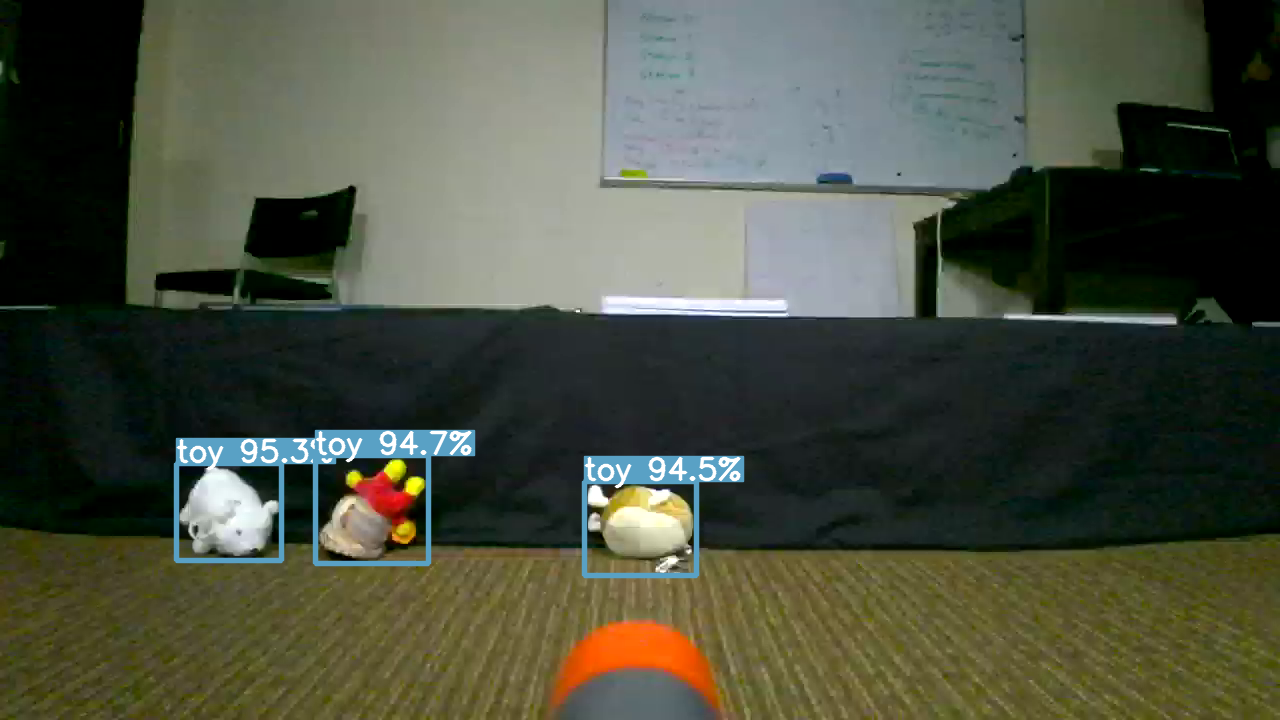

In [ ]:
from PIL import Image
import numpy as np
model = YOLO("/content/drive/MyDrive/OD/train2/weights/best.pt")  # load a pretrained model (recommended for training)
result = model.predict("/content/Datasets/images/test/image_0000.png")
image = Image.open("/content/Datasets/images/test/image_0000.png")
image = np.asarray(image)
plot_bboxes(image, result[0].boxes.data, score=True)


#**Object Detection using Finetuned Yolov8x**

In [ ]:
model = YOLO("/content/drive/MyDrive/OD/train2/weights/best.pt")  # load a pretrained model (recommended for training)

In [ ]:
import pandas as pd
from tqdm import tqdm
import os

ROOT = "." # Change this accordingly
TEST_FOLDER = "/content/Datasets/images/test"

In [ ]:
submission_csv = pd.DataFrame(columns = ["Image_ID", "class", "confidence", "ymin", "xmin", "ymax", "xmax"])
!rm "/content/Datasets/images/test/.DS_Store"
submission_csv.head()

df_len = 0
for i in tqdm(os.listdir(TEST_FOLDER)):
  result = model.predict(TEST_FOLDER  + f"/{i}")
  for box in range(result[0].boxes.data.shape[0]):
    coordinates = result[0].boxes.xyxyn[box].detach().cpu()
    submission_csv.loc[df_len] = [i[:-4], 
                                  0 , 
                                  result[0].boxes.conf[box].detach().cpu().item(), 
                                  coordinates[1].item(), #ymin
                                  coordinates[0].item(), #xmin
                                  coordinates[3].item(), #ymax
                                  coordinates[2].item(), #xmax
                                  ]
    df_len += 1


In [ ]:
submission_csv.to_csv(ROOT + "/submission_yolo8x.csv", index = False)

Now we have a submission.csv file with all the identified plushie in each test image.